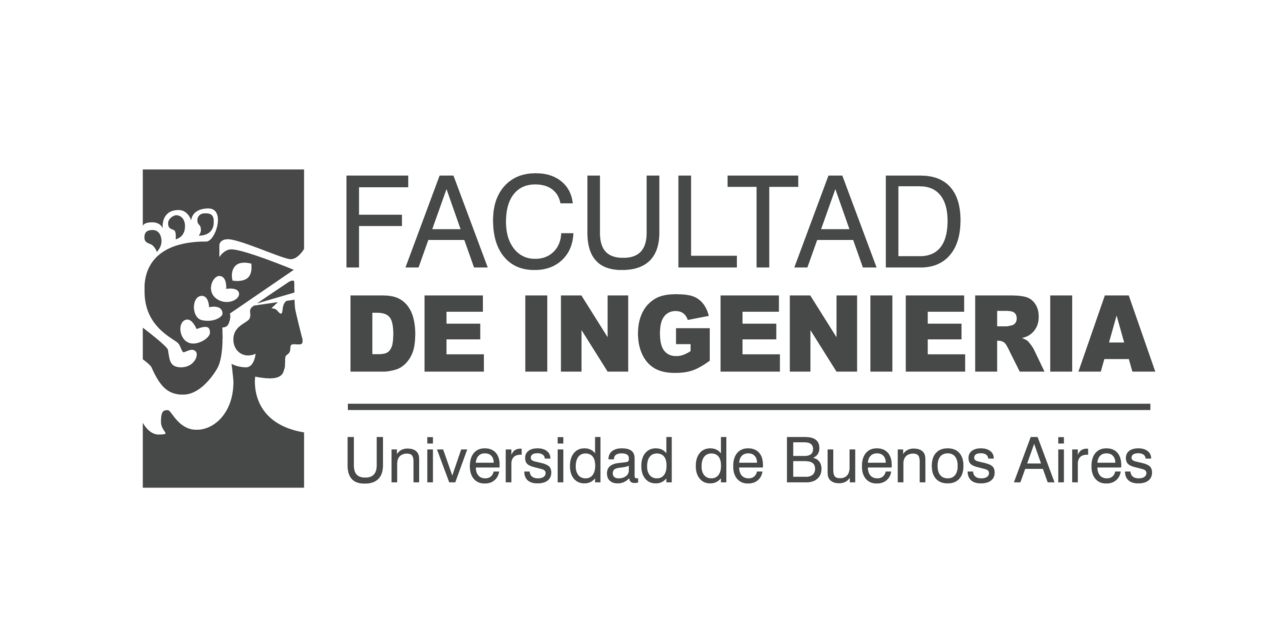

**Profesores:** <br />
Dr. Rodrigo Cardenas Szigety - rodrigo.cardenas.sz@gmail.com <br />
Dr. Nicolás Vattuone - nicolas.vattuone@gmail.com <br />

**Alumno:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/joagonzalez/ceia-nlp - Ver desafios/Desafio_2.ipynb<br />



### Requisitos y utilidades

In [39]:
%pip install gensim
%pip install tensorflow
%pip install scikit-learn
%pip install plotly
%pip install wordcloud
%pip install matplotlib numpy
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (781 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 KB 1.1 MB/s eta 0:00:00 MB/s eta 0:00:01
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [105]:
import re
import nltk
import json
import keras
import random
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import plotly.graph_objects as go
from gensim.models import Word2Vec
from sklearn.manifold import TSNE                   
from sklearn.decomposition import IncrementalPCA    

# Descargar las stopwords en caso de que no estén disponibles
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jgonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Desafío 2

#### Consigna

1. Crear sus propios vectores con Gensim basado en lo visto en clase con otro 
dataset. 
2. Probar términos de interés y explicar similitudes en el espacio de embeddings. 
3. Intentar plantear y probar tests de analogías. 
4. Graficar los embeddings resultantes.
5. Conclusiones.


Se elige un corpus de mitología y religión que utilizará libros de *gutenberg.org* principalemnte.


| Obra              | Autor              | Link de descarga                                |
|-------------------|--------------------|--------------------------------------------------|
| La Odisea         | Homero             | https://www.gutenberg.org/cache/epub/58221/pg58221.txt |
| La Eneida         | Virgilio           | https://www.gutenberg.org/cache/epub/67197/pg67197.txt |
| La Divina Comedia         | Dante    | https://www.gutenberg.org/ebooks/57303 |
| La Biblia | Varios autores     | https://github.com/thiagobodruk/bible/blob/master/json/es_rvr.json |

- Convertir todos los textos a `.txt` plano.
- Limpiar (minúsculas, remover puntuación).
- Tokenizar por verso, párrafo o frase.
- Entrenar modelo Word2Vec con `min_count=2`, `window=5`, `vector_size=100`.
- Explorar analogías como:

Algunas posibles relaciones a validar en test de analogías:

- rey - hombre + mujer ≈ reina
- infierno - pecado + virtud ≈ paraíso
- dante - virgilio + beatriz ≈ guía espiritual
- cielo - virtud + pecado = infierno

#### Carga y AED

Descargamos todos los corpus y los consolidamos en un unico dataset

In [19]:
# Diccionario de documentos del corpus con sus URLs
textos = {
    "la_odisea.txt": "https://www.gutenberg.org/cache/epub/58221/pg58221.txt",
    "la_eneida.txt": "https://www.gutenberg.org/cache/epub/67197/pg67197.txt",
    "la_biblia.txt": "https://raw.githubusercontent.com/thiagobodruk/bible/refs/heads/master/json/es_rvr.json"
}

In [22]:
def download_corpus(nombre_archivo: str, url: str, type: str = "txt") -> None:
    """
    Descarga un archivo de texto desde una URL y lo guarda localmente.

    Args:
        nombre_archivo (str): Nombre del archivo a guardar.
        url (str): URL del archivo a descargar.
    """
    if type == 'txt':
        print(f"Descargando {nombre_archivo}...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(nombre_archivo, "w", encoding="utf-8") as f:
                f.write(response.text)
            print(f"Guardado como {nombre_archivo}")
        else:
            print(f"Error al descargar {url}")
    elif type == 'json':
        print("Descargando la Biblia (JSON)...")
        resp = requests.get(url)
        if resp.status_code == 200:
            biblia_data = json.loads(resp.content.decode("utf-8-sig"))

            with open(nombre_archivo, "w", encoding="utf-8") as f:
                for libro in biblia_data:
                    print(f"Descargando {libro['name']}...")
                    for capitulo in libro["chapters"]:
                        for versiculo in capitulo:
                            f.write(versiculo + "\n")
            print(f"Guardada como {nombre_archivo}")
        else:
            print("No se pudo descargar la Biblia")
            
def build_corpus() -> None:
    for nombre, url in textos.items():
        if 'biblia' not in nombre:
            download_corpus(nombre, url)
        else:
            download_corpus(nombre, url, type='json')
            
    # Combinar todos los archivos .txt en un único archivo llamado corpus.txt
    with open("corpus.txt", "w", encoding="utf-8") as corpus:
        for nombre in textos.keys():
            if nombre.endswith(".txt"):
                with open(nombre, "r", encoding="utf-8") as f:
                    corpus.write(f.read() + "\n")

In [ ]:
build_corpus()

Descargando la_odisea.txt...
Guardado como la_odisea.txt
Descargando la_eneida.txt...
Guardado como la_eneida.txt
Descargando la Biblia (JSON)...
Descargando Genesis...
Descargando Exodus...
Descargando Leviticus...
Descargando Numbers...
Descargando Deuteronomy...
Descargando Joshua...
Descargando Judges...
Descargando Ruth...
Descargando 1 Samuel...
Descargando 2 Samuel...
Descargando 1 Kings...
Descargando 2 Kings...
Descargando 1 Chronicles...
Descargando 2 Chronicles...
Descargando Ezra...
Descargando Nehemiah...
Descargando Esther...
Descargando Job...
Descargando Psalms...
Descargando Proverbs...
Descargando Ecclesiastes...
Descargando Song of Solomon...
Descargando Isaiah...
Descargando Jeremiah...
Descargando Lamentations...
Descargando Ezekiel...
Descargando Daniel...
Descargando Hosea...
Descargando Joel...
Descargando Amos...
Descargando Obadiah...
Descargando Jonah...
Descargando Micah...
Descargando Nahum...
Descargando Habakkuk...
Descargando Zephaniah...
Descargando Hag

In [45]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('corpus.txt', sep='/n', header=None)
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 58220


/tmp/ipykernel_19645/3856363820.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('corpus.txt', sep='/n', header=None)


In [46]:
df.iloc[500:521].head(40)

,0
500,de un varón cuyos blancos huesos se pudren en ...
501,acción de la lluvia ó los revuelven las olas e...
502,"le vieran aportar á Ítaca, preferirían tener l..."
503,ricos de oro y de vestidos. Mas aquél ya murió...
504,"destino, y no hay que esperar en su tornada, a..."
505,hombres terrestres afirme que aún ha de volver...
506,"no amanecerá jamás. Pero, ea, habla y responde..."
507,eres y de qué país procedes? ¿Dónde se hallan ...
508,¿En cuál embarcación llegaste? ¿Cómo los marin...
509,Ítaca? ¿Quiénes se precian de ser? Pues no me ...


In [68]:
def remove_special_characters(text: str) -> str:
    """
    Elimina caracteres especiales y acentos de un texto.

    Args:
        text (str): Texto a limpiar.

    Returns:
        str: Texto limpio.
    """
    reemplazos = {
        r'[áÁ]': 'a',
        r'[éÉ]': 'e',
        r'[íÍ]': 'i',
        r'[óÓ]': 'o',
        r'[úÚ]': 'u',
        r'[ñÑ]': 'n'
    }
    for pattern, replace in reemplazos.items():
        text = re.sub(pattern, replace, text)
    return text

def clean_corpus(df: pd.DataFrame, text_column: str = "texto") -> pd.DataFrame:
    stop_words = set(stopwords.words('spanish'))
    extra_stopwords = {
        "diciendo", "dijo", "asi", "pues", "mas", "ti", "dicho", "la", "asimismo",
        "entonce", "aqui", "oh", "este", "hace", "cada", "aun", "cuanto", 
        "hara", "por", "amen", "ello", "fue"
    }
    
    # Normalizar también las stopwords (sin tildes)
    stop_words = {remove_special_characters(w.lower()) for w in stop_words.union(extra_stopwords)}

    def clean_text(text: str) -> str:
        text = text.lower()
        text = remove_special_characters(text)
        text = re.sub(r'[^\w\s]', '', text)     # quitar puntuación
        text = re.sub(r'\s+', ' ', text)        # quitar múltiples espacios
        palabras = text.split()
        palabras_filtradas = [w for w in palabras if w not in stop_words]
        return ' '.join(palabras_filtradas)
    
    df[text_column] = df[text_column].apply(clean_text)
    return df

def word_cloud(df: pd.DataFrame) -> WordCloud:
    """
    Genera un wordcloud a partir de un dataframe.

    Args:
        df (pd.DataFrame): Dataframe que contiene el texto para el wordcloud.

    Returns:
        WordCloud: Instancia de WordCloud generada a partir del texto.
    """
    # Combinar todo el texto del dataframe en una sola cadena
    text = " ".join(df[0].astype(str).tolist())

    # Crear el wordcloud
    wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text)
    
    return wordcloud

df_clean = clean_corpus(df, text_column=0)
df_clean.iloc[500:521].head(40)


,0
500,varon cuyos blancos huesos pudren continente
501,accion lluvia revuelven olas seno mar
502,vieran aportar itaca preferirian tener pies li...
503,ricos oro vestidos aquel murio victima aciago
504,destino esperar tornada aunque alguno
505,hombres terrestres afirme volver dia regreso
506,amanecera jamas ea habla responde sinceramente
507,pais procedes hallan ciudad padres
508,embarcacion llegaste marineros trajeron
509,itaca precian ser figuro venido


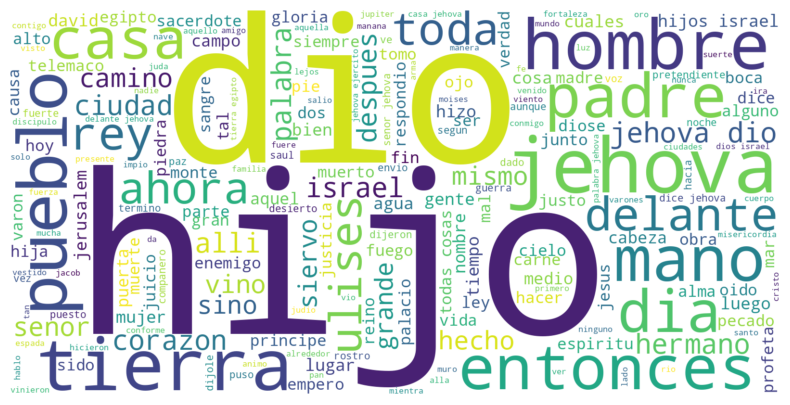

In [70]:
word_cloud_obj = word_cloud(df_clean)

# Mostrar el wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud_obj, interpolation='bilinear')
plt.axis('off')
plt.show()

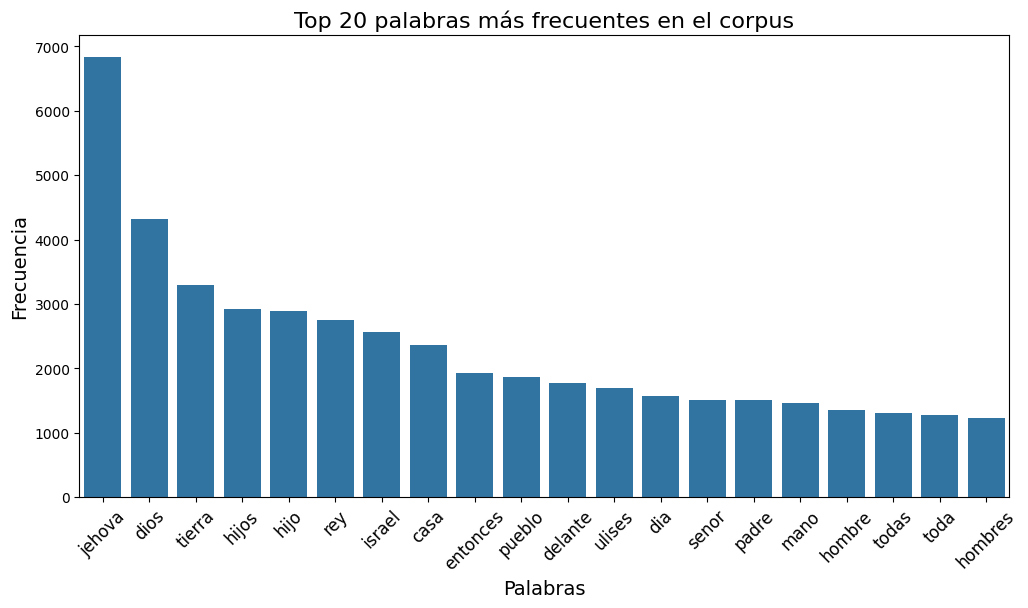

In [82]:
def word_frequency_words(df: pd.DataFrame) -> None:
    """
    Muestra la frecuencia de las palabras en el corpus.
    """
    # Contar la frecuencia de cada palabra en el corpus
    filtered_words = " ".join(df[0].astype(str).tolist()).split()
    word_counts = Counter(filtered_words)

    # Obtener las 20 palabras más frecuentes
    most_common_words = word_counts.most_common(20)

    # Separar las palabras y sus frecuencias para graficar
    words, counts = zip(*most_common_words)

    # Crear el gráfico de barras
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(words), y=list(counts))
    plt.title("Top 20 palabras más frecuentes en el corpus", fontsize=16)
    plt.xlabel("Palabras", fontsize=14)
    plt.ylabel("Frecuencia", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.show()
    
word_frequency_words(df_clean)

#### 1. Crear vectores con Gensim sobre corpus  

In [83]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [86]:
sentence_tokens[500:505]

[['varon', 'cuyos', 'blancos', 'huesos', 'pudren', 'continente'],
 ['accion', 'lluvia', 'revuelven', 'olas', 'seno', 'mar'],
 ['vieran',
  'aportar',
  'itaca',
  'preferirian',
  'tener',
  'pies',
  'ligeros',
  'ser'],
 ['ricos', 'oro', 'vestidos', 'aquel', 'murio', 'victima', 'aciago'],
 ['destino', 'esperar', 'tornada', 'aunque', 'alguno']]

In [87]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [88]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [89]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [90]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de docs en el corpus: 58220
Cantidad de words distintas en el corpus: 11276


In [91]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 3897006.0
Loss after epoch 1: 2381138.0
Loss after epoch 2: 2295702.0
Loss after epoch 3: 2142456.0
Loss after epoch 4: 2071856.0
Loss after epoch 5: 2003187.0
Loss after epoch 6: 1944718.0
Loss after epoch 7: 1797425.0
Loss after epoch 8: 1742852.0
Loss after epoch 9: 1688400.0
Loss after epoch 10: 1649408.0
Loss after epoch 11: 1610334.0
Loss after epoch 12: 1576758.0
Loss after epoch 13: 1546610.0
Loss after epoch 14: 1525506.0
Loss after epoch 15: 1505432.0
Loss after epoch 16: 1488956.0
Loss after epoch 17: 1355360.0
Loss after epoch 18: 1247080.0
Loss after epoch 19: 1267784.0


(7342719, 8766040)

#### 2. Probar términos de interés y explicar similitudes en el espacio de embeddings. 

In [94]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["dios"], topn=10)

[('redentor', 0.5399580001831055),
 ('salvador', 0.5233345031738281),
 ('jehova', 0.5167940855026245),
 ('criador', 0.5162252187728882),
 ('formador', 0.5111480951309204),
 ('concerto', 0.5089704990386963),
 ('eternidad', 0.49832120537757874),
 ('manifestacion', 0.4931059181690216),
 ('sirvais', 0.4906281530857086),
 ('ponerte', 0.49012574553489685)]

In [95]:
w2v_model.wv.most_similar(positive=["tierra"], topn=10)

[('poseerla', 0.5514707565307617),
 ('canaan', 0.5144171714782715),
 ('entras', 0.5030084252357483),
 ('ur', 0.48473870754241943),
 ('habitareis', 0.4803048372268677),
 ('poseais', 0.47989314794540405),
 ('plenitud', 0.4745587706565857),
 ('subiere', 0.4739978313446045),
 ('desierta', 0.47346031665802),
 ('poseas', 0.47230422496795654)]

In [100]:
w2v_model.wv.most_similar(positive=["pueblo"], topn=10)

[('congregacion', 0.3958720862865448),
 ('llegarse', 0.3903186321258545),
 ('caminar', 0.38633182644844055),
 ('desamparare', 0.3857881426811218),
 ('volveis', 0.3817717730998993),
 ('echarlo', 0.3810366094112396),
 ('magistrados', 0.38031449913978577),
 ('orare', 0.37633758783340454),
 ('visitado', 0.3762965202331543),
 ('causas', 0.3755020499229431)]

In [106]:
w2v_model.wv.most_similar(positive=["justicia"], topn=10)

[('benignidad', 0.5291643142700195),
 ('equidad', 0.513141930103302),
 ('manifestacion', 0.5077550411224365),
 ('impiedad', 0.5016577243804932),
 ('eleccion', 0.4954765737056732),
 ('ordenacion', 0.4933130741119385),
 ('injusticia', 0.48908838629722595),
 ('rectos', 0.48883572220802307),
 ('rectitud', 0.4882623553276062),
 ('conocereis', 0.4827543795108795)]

#### 3. Intentar plantear y probar tests de analogías. 

In [ ]:
def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels



In [104]:
vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en cola